## Практическое задание к 8 уроку

Попробуйте улучшить работу нейронной сети рассмотренной в методическом пособии. Приложите анализ. Приложете лучшее сгенерированное изображение к уроку.

## Итоги работы

Заметное улучшение работы генератора достигается существенным увеличением числа эпох. (>150 эпох). Остальные изменения не приводили к заметным улучшениям модели.

Дополнительного улучшения достиг, благодаря обучению второй модели для сегментации лошадей. С помощью сегментационной модели избавился от нежелательной модификации частей изображения, не являющимися лошадьми.

Результат полученный в самом конце работы продублирован сразу ниже:
1.   В первом столбце оригиналы тестовых изображений.
2.   Во втором показана работа генератора. 
3.   В третьем показана работа модели сегментации.
4.   В четвертом итоговые изображения полученные по формуле 
`orig_img * (1 - segm_img) + gan_img * segm_img`.

Больше не искажаются цвета фотографий, не появляются рябь в областях неба и воды на фото.



In [1]:
# for i in range(3):
#     img = (test_imgs[i][0] + 1.) / 2.
#     gen_img = (gen_imgs[i][0] + 1.) / 2.
#     segm_img = np.stack((segm_imgs[i][..., 0],)*3, axis=-1)

#     fig = plt.figure(figsize=(17, 4))

#     ax0 = plt.subplot(1, 4, 1)
#     ax0.imshow(img)
#     ax0.set_title('Оригинал')
#     plt.axis('off')

#     ax1 = plt.subplot(1, 4, 2)
#     ax1.imshow(gen_img)
#     ax1.set_title('GAN')
#     plt.axis('off')

#     ax2 = plt.subplot(1, 4, 3)
#     ax2.imshow(segm_img)
#     ax2.set_title('Segmentation')
#     plt.axis('off')

#     ax3 = plt.subplot(1, 4, 4)
#     ax3.imshow(img * (1 - segm_img) + gen_img * segm_img)
#     ax3.set_title('Итог')
#     plt.axis('off')

## Строим генератор

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import numpy as np
import skimage.io as io
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir -p "/content/Models"

In [6]:
MY_DRIVE_PATH = '/content/Models'

In [7]:
%%capture
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [10]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [11]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [12]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [13]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [14]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

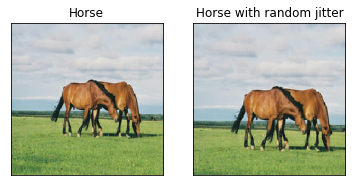

In [15]:
sample_horse = next(iter(train_horses))

plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)
plt.xticks([]); plt.yticks([])

plt.subplot(122)
plt.title('Horse with random jitter')
plt.xticks([]); plt.yticks([])
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)
plt.xticks([]); plt.yticks([])
plt.show()

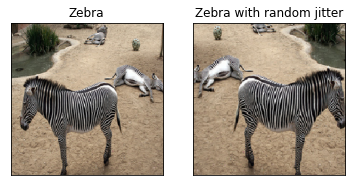

In [16]:
sample_zebra = next(iter(train_zebras))
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)
plt.xticks([]); plt.yticks([])

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)
plt.xticks([]); plt.yticks([])
plt.show()

## Импортирование  Pix2Pix модели
Генератор и дискриминатор мы возьмем из Pix2Pix модели, генерация будет осуществляться с применением Unet.

In [17]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

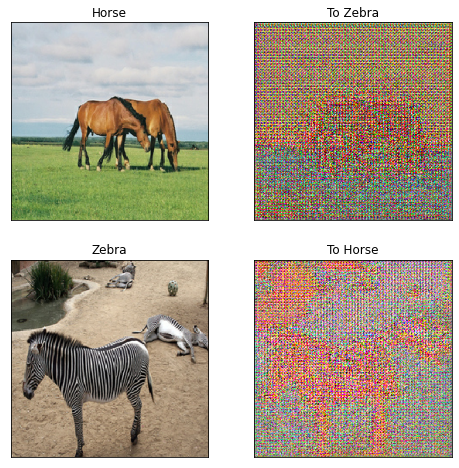

In [18]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
    plt.xticks([]); plt.yticks([])
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
    plt.xticks([]); plt.yticks([])
plt.show()

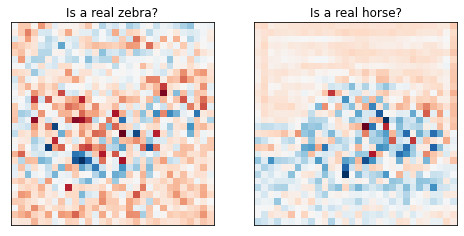

In [19]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')
plt.xticks([]); plt.yticks([])

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')
plt.xticks([]); plt.yticks([])

plt.show()

## Loss functions
Loss функции для генератора и дискриминатора можно взять также из [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [20]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Инициализация оптимайзеров для всех генераторов и всех дискриминаторов.

In [21]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints
Сохранение промежуточных результатов, для того, чтобы при необходимости можно было продолжить обучение, а не начинать сначала.

In [22]:
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, MY_DRIVE_PATH, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Training

По умолчанию кол-во эпох выставлено 1 хотя, для корректного результатов понадобиться от нескольких десятков до нескольких сотен эпох.

In [23]:
EPOCHS = 1

Несмотря на то, что тренировочный процесс у GAN более сложный, он состоит из тех же этапов, что обычно:

* Получить предсказание
* Вычислить ошибку
* Посчитать градиенты используя обратное распространения ошибки.
* Применить градиенты для оптимайзера.

In [24]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                          generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                              discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                              generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))
    
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))

In [25]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

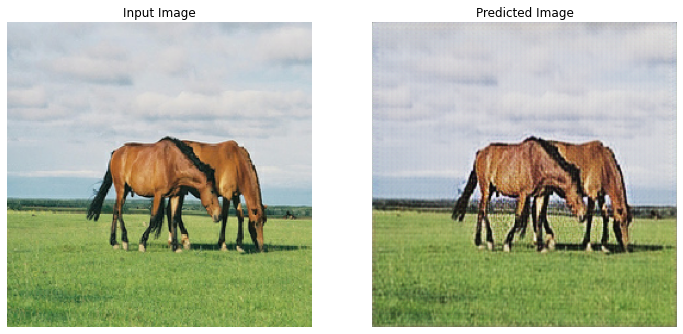

Time taken for epoch 1 is 270.3007318973541 sec

Total time 270.3008916378021



In [26]:
start = time.time()
for epoch in range(EPOCHS):
    epoch_start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_horse)

    

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-epoch_start))
    print ('Total time {}\n'.format(time.time()-start))

## Generate using test dataset

In [27]:
test_imgs = []
gen_imgs = []
for inp in test_horses.take(3):
    test_imgs.append(inp)

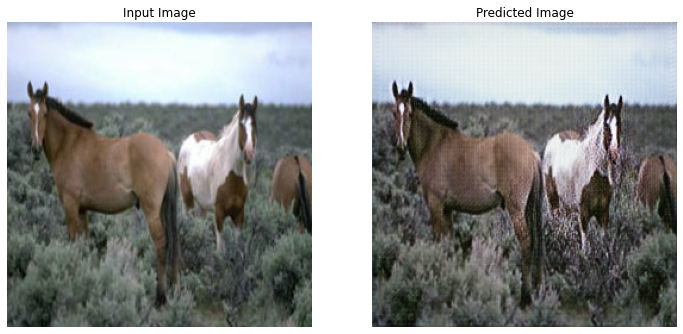

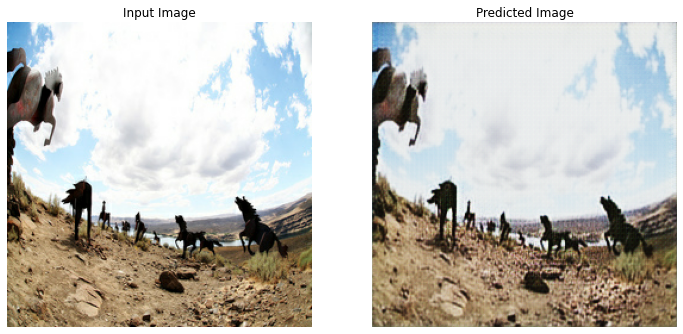

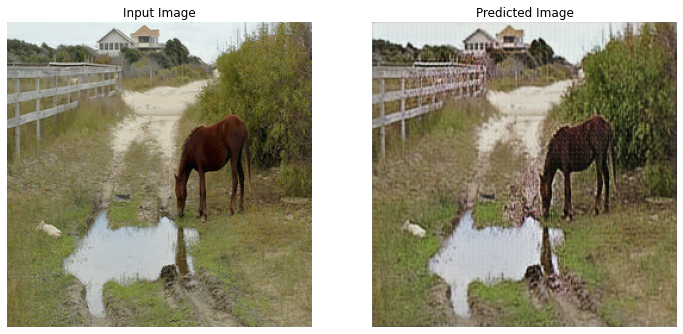

In [28]:
gen_imgs = []
for inp in test_imgs:
    prediction = generator_g(inp)
    gen_imgs.append(prediction)
    plt.figure(figsize=(12, 12))

    display_list = [inp[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Никак не могу избавиться, от изменения фона.

Попробую обучить отдельную нейросеть сегментации лошадей для определения, где именно лошадь на изображении.

### Сегментация лошадей

In [30]:
COCO_ROOT = '/content/COCO'

In [31]:
%%time
if not os.path.isdir(COCO_ROOT):
    !mkdir -p "/content/COCO"

    !cd "/content/COCO" && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd "/content/COCO" && unzip -q train2017.zip
    !cd "/content/COCO" && rm train2017.zip
    
    !cd "/content/COCO" && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd "/content/COCO" && unzip -q val2017.zip
    !cd "/content/COCO" && rm val2017.zip
    
    !cd "/content/COCO" && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
    !cd "/content/COCO" && unzip -q annotations_trainval2017.zip
    !cd "/content/COCO" && rm annotations_trainval2017.zip 

    !cd "/content/COCO" && git clone https://github.com/cocodataset/cocoapi
    !cd "/content/COCO/cocoapi/PythonAPI" && make

--2020-09-25 17:49:38--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.241.76
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.241.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.1MB/s    in 7m 32s  

2020-09-25 17:57:11 (40.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2020-09-25 18:06:48--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.40.100
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.40.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  44.8MB/s    in 18s     

2020-09-25 18:07:06 (43.5 MB/s) - ‘v

### Подготовка COCO API

In [32]:
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Универсальный класс COCO Dataset для сегментации

In [33]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, 4))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :4]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [34]:
CATEGORY = 'horse'

class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        self.sublist = sublist
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=[CATEGORY])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [35]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=12.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


### Параметры обучения

In [36]:
TRAIN_BATCH_SIZE = 16
TRAIN_EPOCHS = 20
VAL_BATCH_SIZE = 16
INPUT_SIZE = 256

### Создаем пайплайны данных

In [37]:
train_ds = COCO_dataset_train.train_dataset(
    TRAIN_BATCH_SIZE, 
    TRAIN_EPOCHS, 
    INPUT_SIZE)

val_ds = COCO_dataset_val.val_dataset(
    VAL_BATCH_SIZE, 
    INPUT_SIZE)

### Строим модель ASPP (Atrous Spatial Pyramid Pooling)

In [38]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

### Процесс обучения

In [44]:
WEIGHTS_FOLDER = os.path.join(COCO_ROOT, 'horse_saved_weights')

segm_model = ASPPNet()

segm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(
        WEIGHTS_FOLDER, 
        'coco_wghts_loss{val_loss:.2f}_acc{val_accuracy:.2f}.hdf5'), 
    save_weights_only=True)

In [45]:
history = segm_model.fit(
    train_ds,
    steps_per_epoch=len(COCO_dataset_train.img_list) // TRAIN_BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=len(COCO_dataset_val.img_list) // VAL_BATCH_SIZE,
    epochs=TRAIN_EPOCHS,
    callbacks=[callback])

Epoch 1/20
183/183 [==============================] - 75s 412ms/step - loss: 0.6311 - accuracy: 0.7870 - val_loss: 0.4538 - val_accuracy: 0.7881
Epoch 2/20
183/183 [==============================] - 74s 405ms/step - loss: 0.4121 - accuracy: 0.8141 - val_loss: 0.4064 - val_accuracy: 0.8059
Epoch 3/20
183/183 [==============================] - 75s 412ms/step - loss: 0.3897 - accuracy: 0.8233 - val_loss: 0.3693 - val_accuracy: 0.8307
Epoch 4/20
183/183 [==============================] - 74s 403ms/step - loss: 0.3580 - accuracy: 0.8396 - val_loss: 0.4029 - val_accuracy: 0.8186
Epoch 5/20
183/183 [==============================] - 76s 413ms/step - loss: 0.3443 - accuracy: 0.8434 - val_loss: 0.3445 - val_accuracy: 0.8441
Epoch 6/20
183/183 [==============================] - 77s 420ms/step - loss: 0.3311 - accuracy: 0.8482 - val_loss: 0.3399 - val_accuracy: 0.8376
Epoch 7/20
183/183 [==============================] - 76s 414ms/step - loss: 0.3057 - accuracy: 0.8618 - val_loss: 0.3740 - val_ac

### Графики обучения

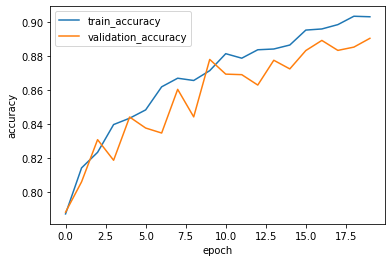

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

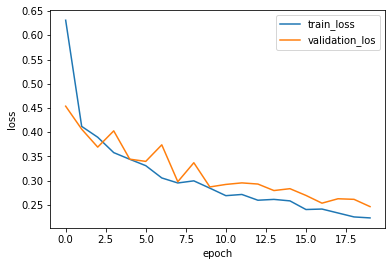

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_los'], loc='best')
plt.show()

##Запуск предсказания на нашем изображении

Используем уже загруженные изображения лошадей для основной задачи

In [48]:
segm_model.load_weights('/content/COCO/horse_saved_weights/coco_wghts_loss0.25_acc0.89.hdf5')

In [49]:
def img_inference(img, treshold=.5):
    img = (img[0] + 1.) / 2.  # plt.imread(img_path).astype(np.float32) / 255
    preds = segm_model(np.array([img]))[0]
    seg_map = np.float32(preds[..., 0] > treshold)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]

    fig = plt.figure(figsize=(19, 4))

    ax0 = plt.subplot(1, 3, 1)
    ax0.imshow(img)
    plt.xticks([]), plt.yticks([])

    ax1 = plt.subplot(1, 3, 3)
    heatmap = ax1.imshow(preds[..., 0])
    plt.xticks([]), plt.yticks([])
    fig.colorbar(heatmap, shrink=1)

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(img * 0.5 + seg_map_clr * 0.5)
    plt.xticks([]), plt.yticks([])

    plt.show()
    return preds

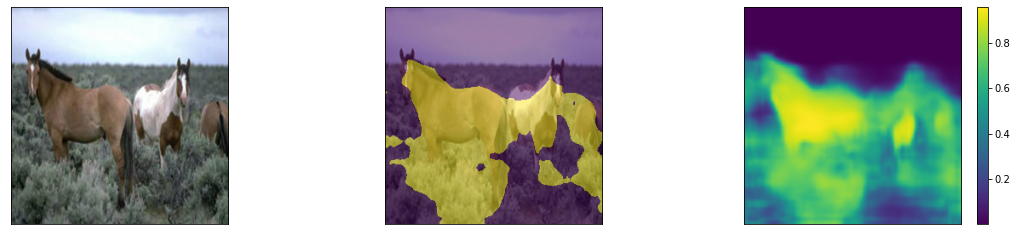

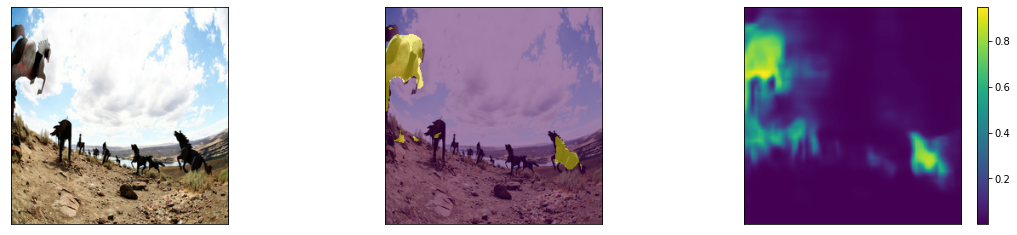

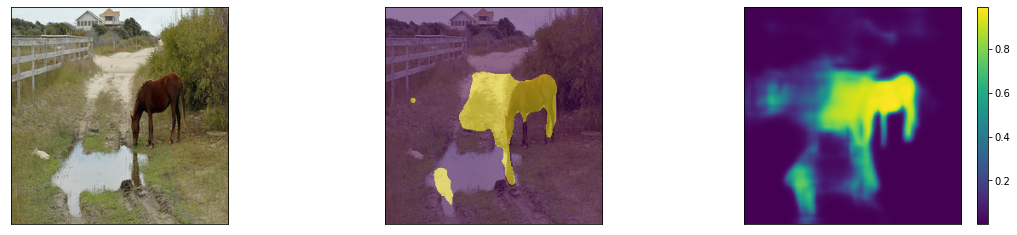

In [50]:
segm_imgs = []
for im in test_imgs:
    segm_imgs.append(img_inference(im, treshold=0.6))

Неплохо сегментируем лошадей

## Комбинируем две модели

Будем модифицировать изображение генератором согласно весам модели семантической сегментации.

In [51]:
def zebrafication(inp):
    # img должна быть нормализована [0, 1]
    gen_img = (generator_g(inp * 2. - 1.) + 1.) / 2.
    segm_img = segm_model(np.array([inp]))[0]
    segm_img = np.stack((segm_img[..., 0],) * 3, axis=-1)
    return img * (1 - segm_img) + gen_img[0] * segm_img

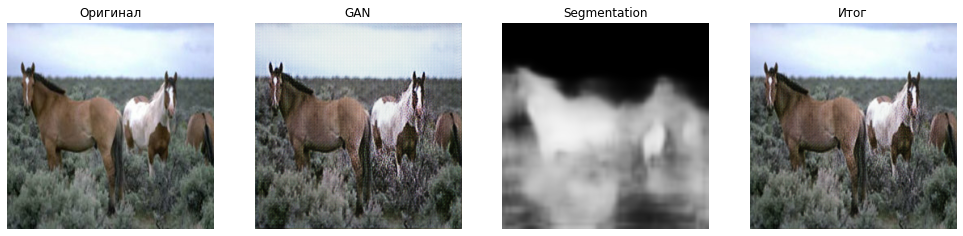

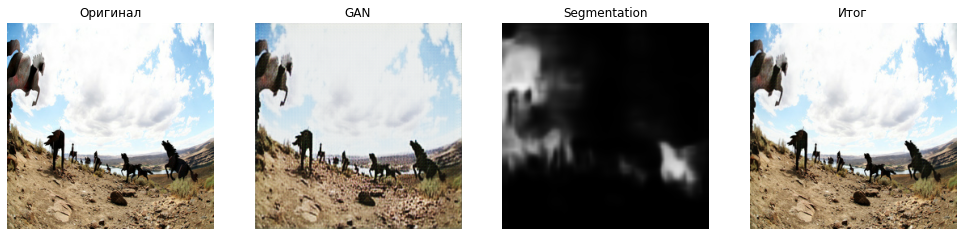

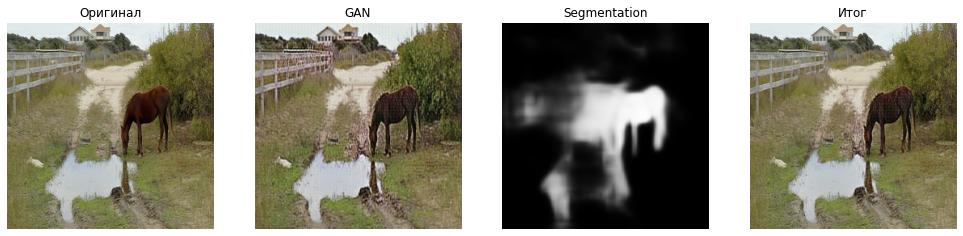

In [52]:
for i in range(3):
    img = (test_imgs[i][0] + 1.) / 2.
    gen_img = (gen_imgs[i][0] + 1.) / 2.
    segm_img = np.stack((segm_imgs[i][..., 0],)*3, axis=-1)

    fig = plt.figure(figsize=(17, 4))

    ax0 = plt.subplot(1, 4, 1)
    ax0.imshow(img)
    ax0.set_title('Оригинал')
    plt.axis('off')

    ax1 = plt.subplot(1, 4, 2)
    ax1.imshow(gen_img)
    ax1.set_title('GAN')
    plt.axis('off')

    ax2 = plt.subplot(1, 4, 3)
    ax2.imshow(segm_img)
    ax2.set_title('Segmentation')
    plt.axis('off')

    ax3 = plt.subplot(1, 4, 4)
    ax3.imshow(img * (1 - segm_img) + gen_img * segm_img)
    ax3.set_title('Итог')
    plt.axis('off')